# Create entropy features for N1904-TF

## Table of content (ToC)<a class="anchor" id="TOC"></a>

* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Setting up the environment</a>
  * <a href="#bullet2x1">2.1 - Load TF code</a>
  * <a href="#bullet2x2">2.1 - Load TF with N1904additons</a>
* <a href="#bullet3">3 - Perform the analyses</a>
  * <a href="#bullet3x1">3.1 - Generate the Pandas DataFrame</a>
  * <a href="#bullet3x2">3.2 - Compute P(function | datatype) per datatype</a>
  * <a href="#bullet3x3">3.3 - Compute entropy per datatype</a>
* <a href="#bullet4">4 - Create the additonal TF features</a>    
  * <a href="#bullet4x1">4.1 - Prepare metadata</a>
  * <a href="#bullet4x2">4.2 - Prepare featuredata</a>
  * <a href="#bullet4x3">4.3 - Link featuredata to metadata</a>
  * <a href="#bullet4x4">4.4 - Save the features to file</a>
  * <a href="#bullet4x5">4.5 - Reload Text-Fabric with the new features</a>
  * <a href="#bullet4x6">4.6 - Check if the new features are loaded</a>
  * <a href="#bullet4x7">4.7 - Print a syntax tree</a>
  * <a href="#bullet4x8">4.8 - Save the newly created features</a>
* <a href="#bullet5">5 - Attribution and footnotes</a>
* <a href="#bullet6">6 - Required libraries</a>
* <a href="#bullet7">7 - Notebook version</a>

#  1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

In this Jupyter Notebook a set of Text-Fabric features are created to visualize the entropy values for three features (datatypes):
   - [`text`](https://centerblc.github.io/N1904/features/text.html): the Greek text as it is found on the surface level 
   - [`morph`](https://centerblc.github.io/N1904/features/morph.html): morphological tag of the word (e.g., N-ASN)
   - [`lemma`](https://centerblc.github.io/N1904/features/lemma.html): base forms of the word (dictionary entry)

The entropy is calculated with respect to the syntactic function of the parent phrase, which is expressed by the phrase [`function`](https://centerblc.github.io/N1904/features/function.html).

In the context of inflectional morphology, such as the Greek of the New Testament, we can view the mapping from morph, text or lemma to syntactic function (expressed by the phrase function) as a distribution over outcomes.  This allows for the quantifaction of the variability of forms in terms of their syntactic behavior.

One could interpret the entropy values as following:
  - Low entropy: a form almost always behaves the same way, indicating a predictable and consistent syntactic function.
  - High entropy: a form is used variably, indicating a more flexible and context-dependent syntactic function.

# 2 - Setting up the environment <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

## 2.1 - Load TF code <a class="anchor" id="bullet2x1"></a> 

First load the TF package.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Loading the Text-Fabric code
from tf.fabric import Fabric
from tf.app import use

## 2.1 - Load TF with N1904additons <a class="anchor" id="bullet2x1"></a> 

In this notebook initialy we only need the N1904-TF base feature set.

In [4]:
# Load the N1904-TF app and data with the additional features
A = use ("CenterBLC/N1904", version="1.0.0", silence="terse", hoist=globals())

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

# 3 - Perform the analyses <a class="anchor" id="bullet3"></a>
##### [Back to ToC](#TOC)

## 3.1 - Generate the Pandas DataFrame <a class="anchor" id="bullet3x1"></a> 

Gather the proper features from the N1904-TF dataset:

In [5]:
import pandas as pd
import re
from tqdm.std import tqdm

# Initialize empty lists to store the output data
df_tf=[]
rows=[]
seen = set()
teller=0  # used for test runs

# store all word nodes in an iterable variable
word_node_list=F.otype.s('word')

# Iterate over each word node in the 'word' type with progress indicator
for wordNode in tqdm(word_node_list, desc="Processing word nodes"):
    teller+=1
    row = {}

    # Store the TF word node number and the value for feature morph in the row
    row['word_id']=wordNode
    row['morph']=F.morph.v(wordNode)
    row['text']=F.text.v(wordNode)
    row['lemma']=F.lemma.v(wordNode)
    # trying to figure out what the upstream subphrase or phrase function could be
    parent_tuple = L.u(wordNode, "phrase")
    if len(parent_tuple)==0:
        # check for subphrase if no parent phrasenode is found
        subphrase_tuple = L.u(wordNode, "subphrase")
        if len(subphrase_tuple)==0:
            print (f'something odd at word node {wordNode} at {T.sectionFromNode(wordNode)} with text {T.text(wordNode)} pos={F.sp.v(wordNode)}')
            continue
        parent_node=subphrase_tuple[0]
        sub='sub'
    else:
        parent_node=parent_tuple[0]
        sub=''
    if parent_node not in seen:
        seen.add(parent_node)
        pf=F.function.v(parent_node)
        # Trying to map 'None' to some more reasonable catagory
        if not pf:
            pos=F.sp.v(wordNode)
            if pos=="conj":
                pf="Conj"
            elif pos=="intj":
                pf="Intj"
            else:
                pf="Unkn" # it may be good to minimize this catagory 
                #print (f'wordnode={wordNode} {sub}phrasefunct={pf} {sub}phrasesize={len_phrase} at {T.sectionFromNode(wordNode)} with text {T.text(wordNode)} pos={pos}')
    
    # store the determined phrase function to the row in the dataframe
    row['phrase_function'] = pf

    # Add this row to the output list
    rows.append(row)
    
# Turn the created list into a DataFrame
df_tf = pd.DataFrame(rows)

Processing word nodes: 100%|██████████| 137779/137779 [00:01<00:00, 127405.92it/s]


In [6]:
# Inspect it
print(df_tf.head())

   word_id  morph      text    lemma phrase_function
0        1  N-NSF    Βίβλος   βίβλος            PreC
1        2  N-GSF  γενέσεως  γένεσις            PreC
2        3  N-GSM     Ἰησοῦ   Ἰησοῦς            PreC
3        4  N-GSM   Χριστοῦ  Χριστός            PreC
4        5  N-GSM      υἱοῦ     υἱός            PreC


## 3.2 - Compute $P(\text{function}\mid\text{datatype})$ function per datatype <a class="anchor" id="bullet3x2"></a>

The following code block computes the empirical distribution of syntactic functions for each `morph`, `text`, and `lemma` in the DataFrame, grouped by datatype. It then uses these distributions to calculate the entropy. In short this can be described as:

For each datatype (`morph`, `text`, and `lemma`), the code:

1. Groups all tokens by `(datatype, phrase_function)` to obtain counts.

2. Normalizes these counts by each datatype's total, resulting in probability distributions of the form:
	* $P(\text{function}\mid\text{morph})$
	* $P(\text{function}\mid\text{text})$
	* $P(\text{function}\mid\text{lemma})$

These distributions represent the empirical probability of each phrase function given for a particular datatype: $P(f\mid d)$, with $d$ being the datatype.

<details><summary><b>Detailed mathematic description</b></summary>
This section describes in more detail the building of the empirical $P(f\mid m)$ from the full GNT (N1904-TF) corpus can be described in mathematical terms as follows. Starting from the raw data, the corpus consist of a set of tokens:

$$
T = \{\,t_1, t_2, \dots, t_{|T|}\}
$$

in this representation, each token $t$ carries two labels:

* a *morph tag* $m(t)\in\mathcal M$ (e.g. “N-NSM”)
* a *phrase-function* $f(t)\in\mathcal F$ (e.g. “Subj”)

The first operation is to perform a counts of each pair $(m,f)$. So to determine how many tokens realize a certain combination:

$$
C(m,f)
\;=\;
\bigl|\{\,t\in T : m(t)=m \text{ and } f(t)=f\}\bigr|.
$$

Next we need to determine the marginal counts. For each morph $m$, count how many tokens carry that morph (regardless of function):

$$
M(m)
\;=\;
\sum_{f\in\mathcal F} C(m,f)
\;=\;
\bigl|\{\,t\in T : m(t)=m\}\bigr|.
$$

From this we can determine the empirical conditional distribution. For this we define:

$$
P(f \mid m)
\;=\;
\frac{C(m,f)}{M(m)},
$$

That means, the fraction of all $m$-tokens that appear with function $f$.  Or more formally:

$$
\sum_{f}P(f\mid m) \;=\;1,
\quad
P(f\mid m)\ge0.
$$

The final mapping is then done by collect these into a (triple indexed) nested dictionary, which can be formalized as:

$$
P_{f\mid m} \;=\;\{\,m:\{\,f:P(f\mid m)\,\}\,\},
$$

This delivers us now a dictionairy that can be used to lookup $P(\text{function}\mid\text{datatype})$.
</details>

In [7]:
# Initialize an empty dict to hold P(phrase_function | datatype) distributions
P_f_given_datatype = {}

# List of datatypes to iterate over
datatypes=['morph','text','lemma']

for datatype in datatypes:
    # Group by the current datatype and phrase_function, count occurrences
    grp = (
        df_tf
        .groupby([datatype, 'phrase_function'])
        .size()
        .reset_index(name='count')
    )
    
    # Compute the total count for each value of the current datatype
    total = (
        df_tf
        .groupby(datatype)
        .size()
        .reset_index(name='total')
    )

    # Merge the grouped counts with the totals for the same datatype value
    dist = grp.merge(total, on=datatype)

    # Compute probability P(phrase_function | datatype) = count / total
    dist['P'] = dist['count'] / dist['total']

    # Prepare nested dict for this datatype
    P_f_given_datatype[datatype] = {}

    # Iterate over each row of the distribution DataFrame
    for _, row in dist.iterrows():
        d = row[datatype]            # the specific datatype value (e.g. a particular 'morph')
        f = row['phrase_function']   # the phrase function label
        p = row['P']                 # the computed conditional probability

        # Ensure there's a dict for this datatype value
        P_f_given_datatype[datatype][d] = P_f_given_datatype[datatype].get(d, {})
        
        # Store the probability under P_f_given_datatype[datatype][datatype_value][phrase_function]
        P_f_given_datatype[datatype][d][f] = p

Once we have runned the code block, we can check the first few entries for each datatype in the combined dictionairy:

In [7]:
for datatype, dist in P_f_given_datatype.items():
    print(f"Datatype: {datatype}")
    for key, value in dict(list(dist.items())[:2]).items():
        print(f"  {key}: {value}")
    print()

Datatype: morph
  A-APF: {'Adv': 0.018018018018018018, 'Cmpl': 0.40540540540540543, 'Conj': 0.036036036036036036, 'Objc': 0.38738738738738737, 'PreC': 0.10810810810810811, 'Pred': 0.018018018018018018, 'Subj': 0.018018018018018018, 'Unkn': 0.009009009009009009}
  A-APF-C: {'Cmpl': 0.45454545454545453, 'Conj': 0.09090909090909091, 'Objc': 0.36363636363636365, 'Subj': 0.09090909090909091}

Datatype: text
  ΑΓΝΩΣΤΩ: {'Cmpl': 1.0}
  ΑΝΑΘΕΜΑ: {'PreC': 1.0}

Datatype: lemma
  Αἰγύπτιος: {'Cmpl': 0.2, 'Objc': 0.4, 'PreC': 0.2, 'Subj': 0.2}
  Αἰθίοψ: {'Unkn': 1.0}



Now check it for the word λόγος, which from an earlier TF-Query we know is found 63 times in the N1904-TF:

In [12]:
# Look up the dict of phrase_function → probability for “λόγος”
logos_dist = P_f_given_datatype["text"].get("λόγος", {})

# Since we expect exactly 63 occurrences of “λόγος” we can map this to actual:
for phrase_function, prob in logos_dist.items():
    count_estimate = prob * 63
    print(f"{phrase_function}: {count_estimate:.2f}  prob:{prob}")

Conj: 2.00  prob:0.031746031746031744
PreC: 3.00  prob:0.047619047619047616
Pred: 1.00  prob:0.015873015873015872
Subj: 55.00  prob:0.873015873015873
Unkn: 2.00  prob:0.031746031746031744


## 3.3 - Compute entropy per datatype <a class="anchor" id="bullet3x3"></a>

This codeblock computes the Shannon entropy for each of the datatypes. 

<details><summary><b>Detailed mathematic description</b></summary>
The formula to calculate entropy is:

$$
H = -\sum_{i} p_i \log_2 p_i
$$

Since we substitue $p_i$ with $P(\text{f}\mid\text{datatype})$ the resulting formula will look like:

$$
H(\text{datatype}) \;=\; -\sum_f P(f\mid\text{datatype})\,\log_2 P(f\mid\text{datatype})
$$

Under the condition that $\sum_i p_i = 1$ (i.e., the sum of all probabilities add up to 1, which we ensured in the previous codeblock)
</details>

In [19]:
import math

# List of datatypes to iterate over
datatypes = ['morph', 'text', 'lemma']  

# We'll keep a separate entropy dict for each datatype
entropies_by_datatype = {}


def calculate_entropy(dist):
    """
    Compute Shannon entropy (in bits) of a probability distribution `dist`.
    """
    entropy = 0.0
    for p in dist.values():
        
        # skip zeros to avoid log2(0)
        if p > 0:

            # calculate the entropy value
            entropy -= p * math.log2(p)
            
    return entropy

# Compute and store entropies for each datatype
for datatype, dist in P_f_given_datatype.items():
    
    # Temporary dict for this datatype
    ent = {}
    
    # Calculate entropy of each specific token/form → phrase_function distribution
    for token, prob_dist in dist.items():
        # calculate entropy, typecast it to string and limit it to 6 characters
        ent[token] = calculate_entropy(prob_dist)

    # Store under its datatype
    entropies_by_datatype[datatype] = ent

## Performing some stats on the entropy

Now we can print the first few item-entropy values per datatype in the dictionary.

In [20]:
# Now print each datatype’s entropies separately
for datatype, ent in entropies_by_datatype.items():
    print(f"Datatype: {datatype}")
    # Pick a slice of tokens to display (e.g. first 10)
    for token, h in list(ent.items())[:5]:
        print(f"  {token}: {h}")
    print()

Datatype: morph
  A-APF: 1.9522327690917325
  A-APF-C: 1.6767370300521325
  A-APF-S: 0.0
  A-APM: 2.003100596880211
  A-APM-C: 1.4411535278793055

Datatype: text
  ΑΓΝΩΣΤΩ: 0.0
  ΑΝΑΘΕΜΑ: 0.0
  Αἰγυπτίων: 0.0
  Αἰγύπτιοι: 0.0
  Αἰγύπτιον: 0.0

Datatype: lemma
  Αἰγύπτιος: 1.9219280948873623
  Αἰθίοψ: 0.0
  Αἰνέας: 1.0
  Αἰνών: 0.0
  Αἴγυπτος: 0.7943095546405661



Check the value for the text λόγος: 

In [21]:
entropies_by_datatype['text']['λόγος']

0.7910946576900793

In [22]:
# Aggregate into lists
import numpy as np

entropy_lists = {
    datatype: list(token2e.values())
    for datatype, token2e in entropies_by_datatype.items()
}

In [23]:
for datatype, vals in entropy_lists.items():
    arr = np.array(vals)
    print(f"\n=== {datatype} ===")
    print(f"Count:   {arr.size}")
    print(f"Min:     {arr.min():.4f}")
    print(f"25%ile:  {np.percentile(arr, 25):.4f}")
    print(f"Median:  {np.median(arr):.4f}")
    print(f"75%ile:  {np.percentile(arr, 75):.4f}")
    print(f"Max:     {arr.max():.4f}")
    print(f"Mean:    {arr.mean():.4f}")
    print(f"StdDev:  {arr.std(ddof=1):.4f}")


=== morph ===
Count:   1055
Min:     0.0000
25%ile:  0.0000
Median:  0.0000
75%ile:  0.9196
Max:     2.7196
Mean:    0.4893
StdDev:  0.6413

=== text ===
Count:   19446
Min:     0.0000
25%ile:  0.0000
Median:  0.0000
75%ile:  0.0000
Max:     2.5651
Mean:    0.1843
StdDev:  0.4431

=== lemma ===
Count:   5396
Min:     0.0000
25%ile:  0.0000
Median:  0.0000
75%ile:  1.0000
Max:     2.7358
Mean:    0.4840
StdDev:  0.7059


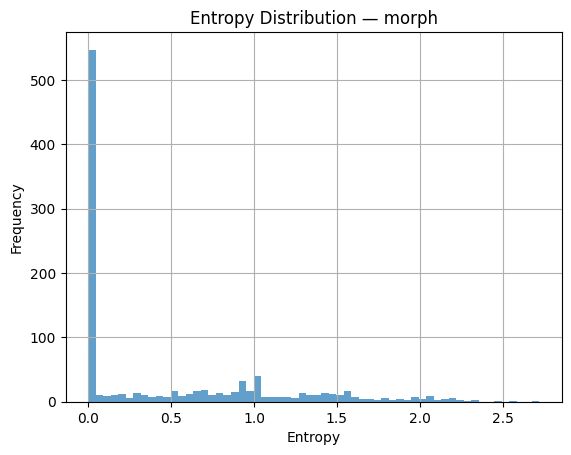

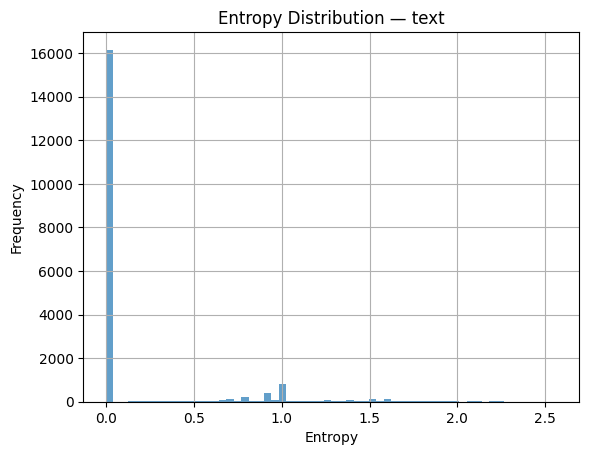

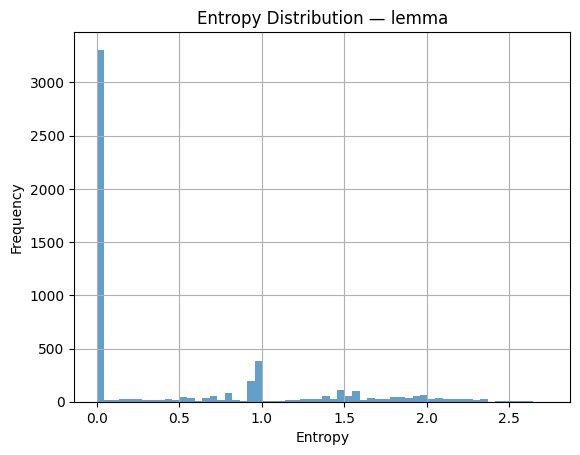

In [49]:
import matplotlib.pyplot as plt

# Histogram for each datatype
for datatype, vals in entropy_lists.items():
    plt.figure()
    plt.hist(vals, bins=60, alpha=0.7)
    plt.title(f"Entropy Distribution — {datatype}")
    plt.xlabel("Entropy")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# 4 - Create the additional TF features <a class="anchor" id="bullet4"></a>
##### [Back to ToC](#TOC)

Now add these as yet another set of Text-Fabric features.

## 4.1 - Prepare metadata <a class="anchor" id="bullet4x1"></a>

As usual, start with a helper function to easily create Metadata for multiple features in one go.

In [37]:
# Common Text-Fabric metadata template function
def createMetadata(description,type):
    return {
        'author': 'Morpheus (perseids-tools)',
        'convertedBy': 'Tony Jurg',
        'website': 'https://github.com/tonyjurg/N1904addon', 
        'description': description,
        'coreData': 'Nestle 1904 Text-Fabric (centerBLC)',
        'coreDataUrl': 'https://github.com/CenterBLC/N1904',
        'provenance': 'jupyter Notebook (https://github.com/tonyjurg/create_TF_feature_betacode)',
        'version': '1.0.0',   # This is the version of the N1904-TF dataset against which this feature is build!
        'license': 'MIT License',
        'licenseUrl': 'https://mit-license.org/',
        'valueType': type
    }


Define the specifics for each feature we are going to add.

In [38]:
# Create metadata for Morpheus Analytic (ma_xxx) features using createMetadata function
morph_entr_Metadata  = createMetadata('Entropy for morph to parent phrase function in the N1904-TF corpus','str')
text_entr_Metadata   = createMetadata('Entropy for surface text to parent phrase function in the N1904-TF corpus','str')
lemma_entr_Metadata  = createMetadata('Entropy for lemma to parent phrase function in the N1904-TF corpus','str')

Let us now first check if it all stitches together properly.

In [39]:
morph_entr_Metadata

{'author': 'Morpheus (perseids-tools)',
 'convertedBy': 'Tony Jurg',
 'website': 'https://github.com/tonyjurg/N1904addon',
 'description': 'Entropy for morph to parent phrase function in the N1904-TF corpus',
 'coreData': 'Nestle 1904 Text-Fabric (centerBLC)',
 'coreDataUrl': 'https://github.com/CenterBLC/N1904',
 'provenance': 'jupyter Notebook (https://github.com/tonyjurg/create_TF_feature_betacode)',
 'version': '1.0.0',
 'license': 'MIT License',
 'licenseUrl': 'https://mit-license.org/',
 'valueType': 'str'}

## 4.2 - Prepare feature data <a class="anchor" id="bullet4x2"></a>

Now we are going to create the dictionairies to store the real data. At the top of this block we define empty dictionairies as placeholders to be filled in the rest of the block.

In [40]:
# Looping over word nodes and populating node feature dictionaries
from tqdm.std import tqdm

# The following dictionaries are defined to store the actual data to create the TF features
morph_entr_Dict    = {}
text_entr_Dict     = {}
lemma_entr_Dict    = {}

# The following dictionaries are added to allow for a nicer print in the next block
text_Dict          = {} 
morph_Dict         = {} 
lemma_Dict         = {} 

counter=0 # only for testing purposes

# Obtain a list of all word ndes 
word_node_list=F.otype.s('word')

# Itterate over all the word nodes
for wordNode in tqdm(word_node_list, desc="Processing word nodes"):
    # increase the test counter
    counter +=1

    # Obtain the details for this word node which will be used as key for the lookups
    this_text=F.text.v(wordNode)
    this_morph=F.morph.v(wordNode)
    this_lemma=F.lemma.v(wordNode)

    # Perform the lookups for the entropies per datatype
    text_entr_Dict[wordNode]   = str(entropies_by_datatype["text"][this_text])[:8]
    morph_entr_Dict[wordNode]  = str(entropies_by_datatype["morph"][this_morph])[:8]
    lemma_entr_Dict[wordNode]  = str(entropies_by_datatype["lemma"][this_lemma])[:8]

    # Store the word details to allow for the nice printout
    text_Dict[wordNode]        = this_text
    morph_Dict[wordNode]       = this_morph
    lemma_Dict[wordNode]       = this_lemma    

    # Exit when running in test mode after preset number
    #if counter==10: break


Processing word nodes: 100%|██████████| 137779/137779 [00:00<00:00, 284053.11it/s]


Now we can examine the results.

In [41]:
import pandas as pd

# Build a DataFrame from the text-dict with the three entropy‐dicts
df_ent = pd.DataFrame({
    'this_text'  : text_Dict,
    'text_ent'   : text_entr_Dict,
    'this_morp'  : morph_Dict,
    'morph_ent'  : morph_entr_Dict,
    'this_lemma' : lemma_Dict,
    'lemma_ent'  : lemma_entr_Dict,    
})

# The wordNode keys become the index, and each dict is a column
print(df_ent.head(10))   # first 10 rows

    this_text  text_ent this_morp morph_ent this_lemma lemma_ent
1      Βίβλος       0.0     N-NSF  1.329976     βίβλος  1.156779
2    γενέσεως  0.918295     N-GSF  2.058534    γένεσις  1.921928
3       Ἰησοῦ  1.949441     N-GSM  2.147433     Ἰησοῦς  2.051067
4     Χριστοῦ  2.018953     N-GSM  2.147433    Χριστός  2.186491
5        υἱοῦ       1.0     N-GSM  2.147433       υἱός  2.300102
6      Δαυεὶδ  2.308708     N-PRI  2.543998      Δαυίδ  2.521229
7        υἱοῦ       1.0     N-GSM  2.147433       υἱός  2.300102
8      Ἀβραάμ  2.124933     N-PRI  2.543998     Ἀβραάμ  2.444218
9      Ἀβραὰμ  2.364475     N-PRI  2.543998     Ἀβραάμ  2.444218
10  ἐγέννησεν       0.0  V-AAI-3S  0.055461     γεννάω       0.0


## 4.3 - Link featuredata to metadata<a class="anchor" id="bullet4x3"></a>

Now we give the new feature its real TF name, and connect this name with the names of the related data dictionary and metadata dictionary.

In [42]:
metadata ={ 
    'morph_entr':     morph_entr_Metadata,
    'text_entr':      text_entr_Metadata,
    'lemma_entr':     lemma_entr_Metadata,
}

In [43]:
nodedata = {
    'morph_entr':     morph_entr_Dict,
    'text_entr':      text_entr_Dict,
    'lemma_entr':     lemma_entr_Dict,
}

## 4.4 - Save the feature to files<a class="anchor" id="bullet4x4"></a>

Now we save the new feature to its own `.tf` file.

If you don’t pass an explicit target path, `TF.save()` writes the file to the directory that already contains the loaded corpus—in this case the local on‑disk copy of the N1904 Text‑Fabric dataset.

In [44]:
TF.save(nodeFeatures=nodedata, metaData=metadata)  # silent="terse"

  0.00s Exporting 3 node and 0 edge and 0 configuration features to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0:
   |     0.14s T lemma_entr           to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0
   |     0.13s T morph_entr           to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0
   |     0.13s T text_entr            to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0
  0.40s Exported 3 node features and 0 edge features and 0 config features to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0


True

## 4.5 - Reload Text-Fabric with the new features <a class="anchor" id="bullet4x5"></a>

Next we’ll confirm that Text‑Fabric can pick up the new features. For this we need to also load the N1904addons.

In [18]:
# load the N1904-TF app and data in another instance 
N1904_ADD = use ('CenterBLC/N1904', mod="tonyjurg/N1904addons/tf/", silent="terse")

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

## 4.6 - Check if the new features are loaded <a class="anchor" id="bullet4x6"></a>

This can be done easily using the 'A.isLoaded()' method:

In [19]:
A.isLoaded(['lemma_entr','text_entr','morph_entr'])

lemma_entr           NOT LOADED
morph_entr           NOT LOADED
text_entr            NOT LOADED


In [20]:
N1904_ADD.isLoaded(['lemma_entr','text_entr','morph_entr'])

lemma_entr           node (str) Entropy for lemma to parent phrase function in the N1904-TF corpus
morph_entr           node (str) Entropy for morph to parent phrase function in the N1904-TF corpus
text_entr            node (str) Entropy for surface text to parent phrase function in the N1904-TF corpus


## 4.7 - Print a syntax tree <a class="anchor" id="bullet4x7"></a>

In [21]:
# Define the query template
VerseQuery = '''
book book=John
  chapter chapter=1
    verse verse=1
'''
VerseResult = N1904_ADD.search(VerseQuery)


featureList = (
    ['lemma','morph']
+   ['lemma_entr','text_entr','morph_entr']
)

N1904_ADD.show(VerseResult,hiddenTypes={'wg','subphrase'}, extraFeatures=featureList, queryFeatures=False)

  0.01s 1 result


## 4.8 - Save the newly created features <a class="anchor" id="bullet4x8"></a>

The last step is to obtain the newly created feature from location ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0 (see output of <a href="#bullet4x4">step 4.4</a>) and move them to its new location: https://github.com/tonyjurg/N1904addons/tree/main/tf/1.0.0.

# 4 - Attribution and footnotes <a class="anchor" id="bullet"></a>
##### [Back to ToC](#TOC)

Greek base text: Nestle1904 Greek New Testament, edited by Eberhard Nestle, published in 1904 by the British and Foreign Bible Society. Transcription by [Diego Santos](https://sites.google.com/site/nestle1904/home). Public domain.


# 5 - Required libraries<a class="anchor" id="bullet5"></a>
##### [Back to ToC](#TOC)

Since the scripts in this notebook utilize Text-Fabric, [it requires currently (Apr 2025) Python >=3.9.0](https://pypi.org/project/text-fabric) together with the following libraries installed in the environment:

    tqdm.std
    math
    re
    pandas
    
You can install any missing library from within Jupyter Notebook using either`pip` or `pip3`.

# 6 - Notebook version<a class="anchor" id="bullet6"></a>
##### [Back to ToC](#TOC)

<div style="float: left;">
  <table>
    <tr>
      <td><strong>Author</strong></td>
      <td>Tony Jurg</td>
    </tr>
    <tr>
      <td><strong>Version</strong></td>
      <td>1.0</td>
    </tr>
    <tr>
      <td><strong>Date</strong></td>
      <td>22 May 2025</td>
    </tr>
  </table>
</div>